In [53]:
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

In [54]:
def display(img):
  # for i, page_img in enumerate(pages):
  plt.figure(figsize=(8, 10))
  plt.imshow(img)
  plt.axis('off')
  plt.show()



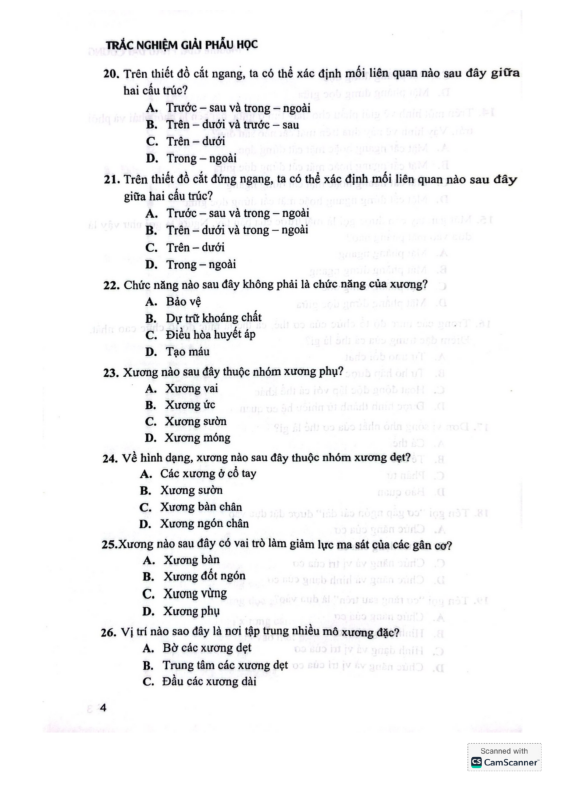

In [55]:
pdf_path = "Module GPDC-2.pdf"
pages = convert_from_path(pdf_path)
display(pages[3])


In [56]:
import numpy as np
import cv2

temp_img = pages[0]
temp_img_2 = pages[5]

first_page = np.array(temp_img)
second_page = np.array(temp_img_2)
print(type(first_page))

<class 'numpy.ndarray'>


# Crop the header

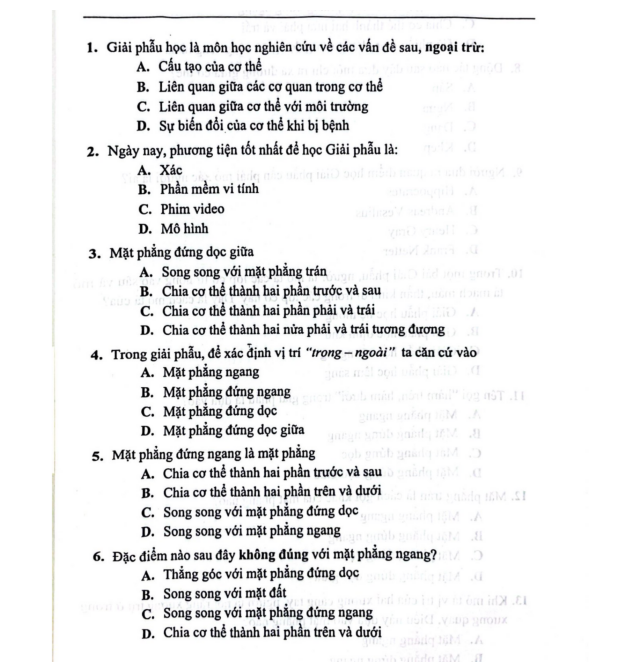

In [57]:
# first_page is a NumPy array representing the image
header_height = 300  # pixels to remove from the top
footer_height = 300  # pixels to remove from the bottom

first_page = first_page[header_height:-footer_height, :, :]
display(first_page)

# Crop the second page

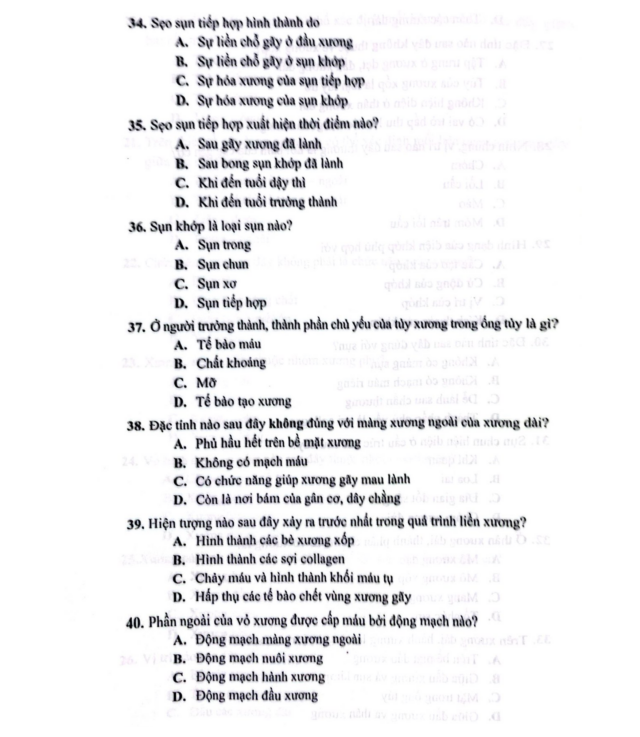

In [58]:
# first_page is a NumPy array representing the image
header_height = 175  # pixels to remove from the top
footer_height = 250  # pixels to remove from the bottom

second_page = second_page[header_height:-footer_height, :, :]
display(second_page)

# Dilation and Threshold

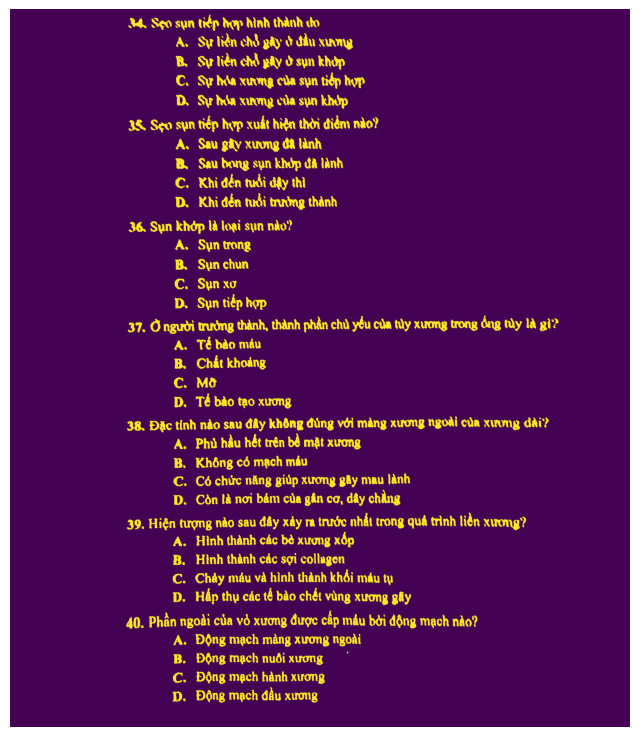

In [59]:
gray = cv2.cvtColor(second_page, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

display(thresh)

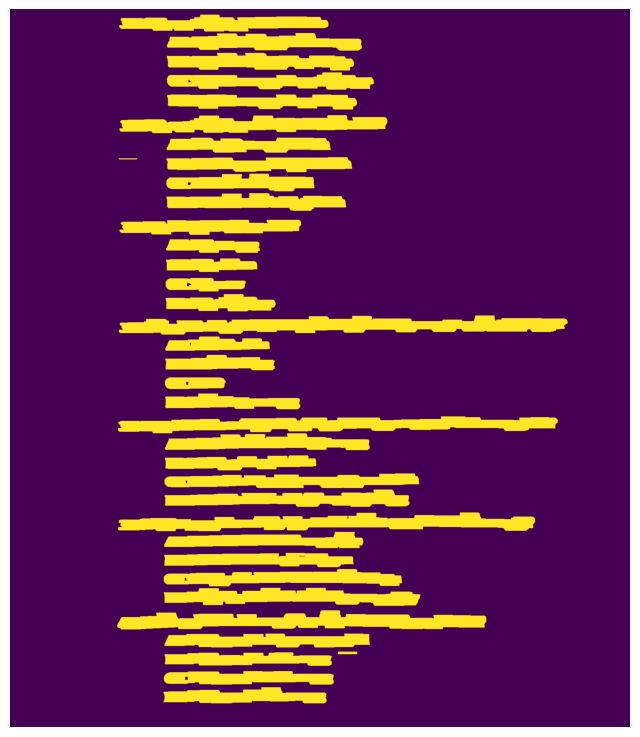

In [60]:
# 3. Dilation
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 2))
dilate = cv2.dilate(thresh, kernel, iterations=2)
display(dilate)


In [61]:
contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
blocks = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if h > 29 and w > 60: 
        roi = second_page[y:y+h, x:x+w]
        blocks.append((y, roi))

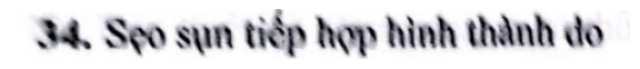

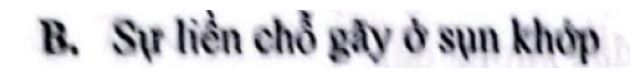

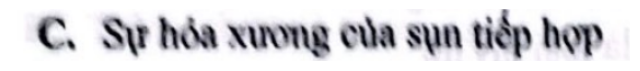

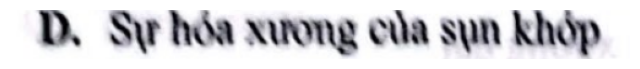

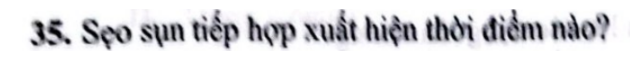

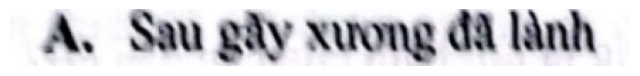

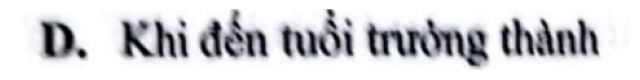

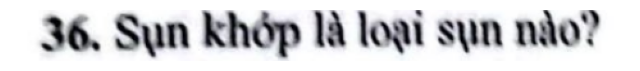

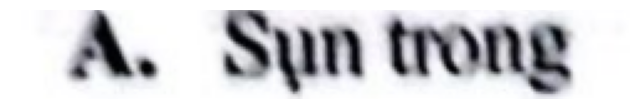

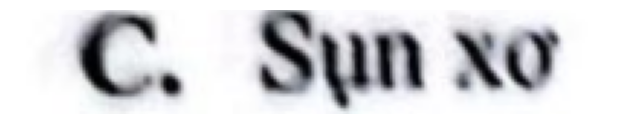

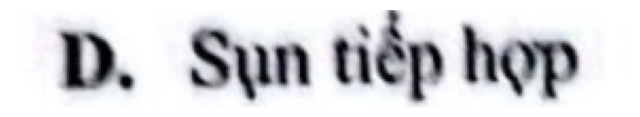

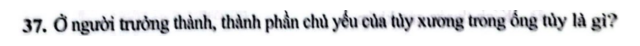

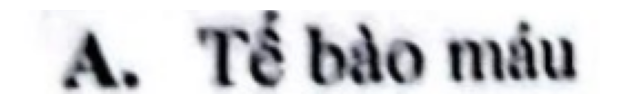

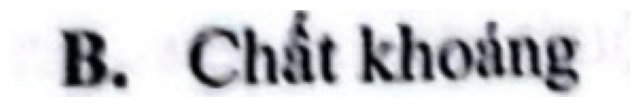

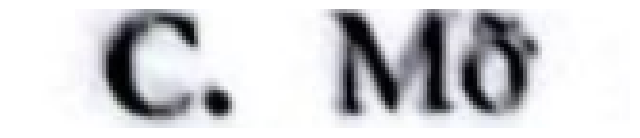

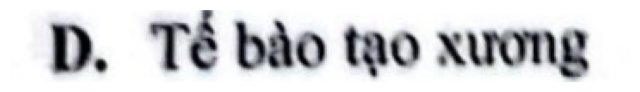

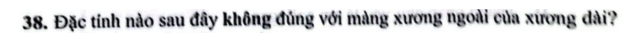

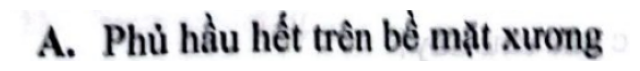

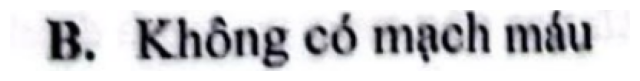

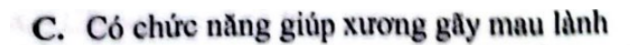

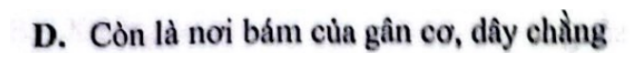

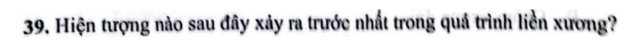

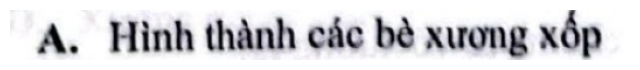

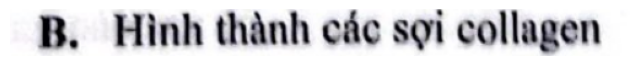

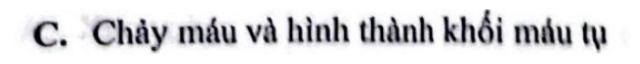

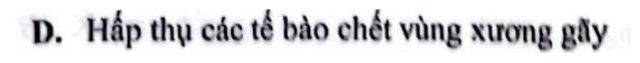

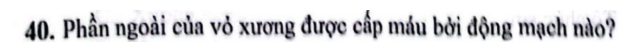

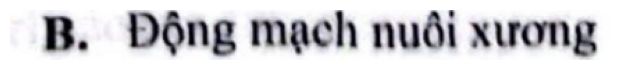

In [62]:
blocks = sorted(blocks, key=lambda b: b[0])
for _, roi in blocks:
    if roi.size > 0:
        display(roi)

# OCR processing

In [63]:
import pytesseract
from pprint import pprint
config = "--oem 1 --psm 7 -l vie"

data = []

for _, roi in blocks:
    roi = cv2.resize(roi, None, fx=4, fy=4, interpolation=cv2.INTER_LANCZOS4)
    text = pytesseract.image_to_string(roi, config=config)
    text = text.replace("\n", " ")
    text = text.replace("ŒC.", "C.")
    text = text.replace("Œ.", "C.")
    text = text.replace("Á.", "A.")
    data.append(text)

pprint(data)

['34, Ñẹo sụn tiếp hợp hình thành do ',
 'À. Ñự liền chỗ gầy ò đầu xương ',
 'lR, Sự liên chề gầy ở sụn khỏp ',
 '€. Sự hỏa xương cùa sụn tiên hợp ',
 'Ù. Ñự hóa xương của sụn khỏp ',
 '3&, Seo sụn tiếp hợp xuất hiện thời điểm nào? ',
 'AÀ. Nau gầy xương đã lành ',
 'R, Sau bong sụn khớp đà lành ',
 '€. Khi đến tuổi đậy thì ',
 'D.. Khi đến tuôi trường thành ',
 '36. Sụn khớp là loại sụn nào? ',
 'À. Nụn trone ',
 'B. Sun chun ',
 'C. Sụn xơ ',
 'D. Sụn tiếp hợp ',
 '37. Ở người trường thành, thành phần chủ yếu của tủy sương trong ông tùy là '
 'gì? ',
 'A. Tế bào máu ',
 'B. Chất khoảng ',
 'C. Mỡ ',
 'D. TẾ bào tạo xương ',
 '38. Đặc tỉnh nào sau đây không đủng với màng xương ngoài của xương đài? ',
 'À. Phủ hầu hết trên bề mặt xương ',
 'B. Không có mạch máu ',
 'C. Có chức năng giúp xương gầy mau lành ',
 'D. Còn là nơi bám của gân cơ, đây chẳng ',
 '39, Hiện tượng nào sau đây xảy ra trước nhẤt trong quả trình liền xương? ',
 'A. Hình thành các bè xương xếp ',
 'B. Hình thành các s

# Save in structure Fields

In [64]:
def is_answer(line):
  options = ['A.', 'B.', 'C.', 'D.']
  return any(opt in line for opt in options)

In [65]:
import json
import re

questions = []
i = 0

while i < len(data):
    line = data[i].strip()


    if re.match(r"^\d+\.", line):
        question_lines = [line]
        i += 1

        # Gom các dòng tiếp theo cho đến khi gặp "A."
        while i < len(data) and not data[i].strip().startswith("A."):
            question_lines.append(data[i].strip())
            i += 1

        question_text = " ".join(question_lines)

        # Lấy 4 đáp án
        options = {}
        for opt in ["A.", "B.", "C.", "D."]:
            if i < len(data) and data[i].strip().startswith(opt):
                options[opt[0]] = data[i].strip()
                i += 1
            else:
                options[opt[0]] = ""  # phòng trường hợp thiếu đáp án

        # Lưu vào list
        questions.append({
            "Question": question_text,
            **options
        })
    else:
        i += 1  # bỏ qua dòng không phải câu hỏi

# Xuất ra file JSON
with open("questions.json", "w", encoding="utf-8") as f:
    json.dump(questions, f, ensure_ascii=False, indent=2)

print("✅ Saved to questions.json")


✅ Saved to questions.json


# Altering Coordinates

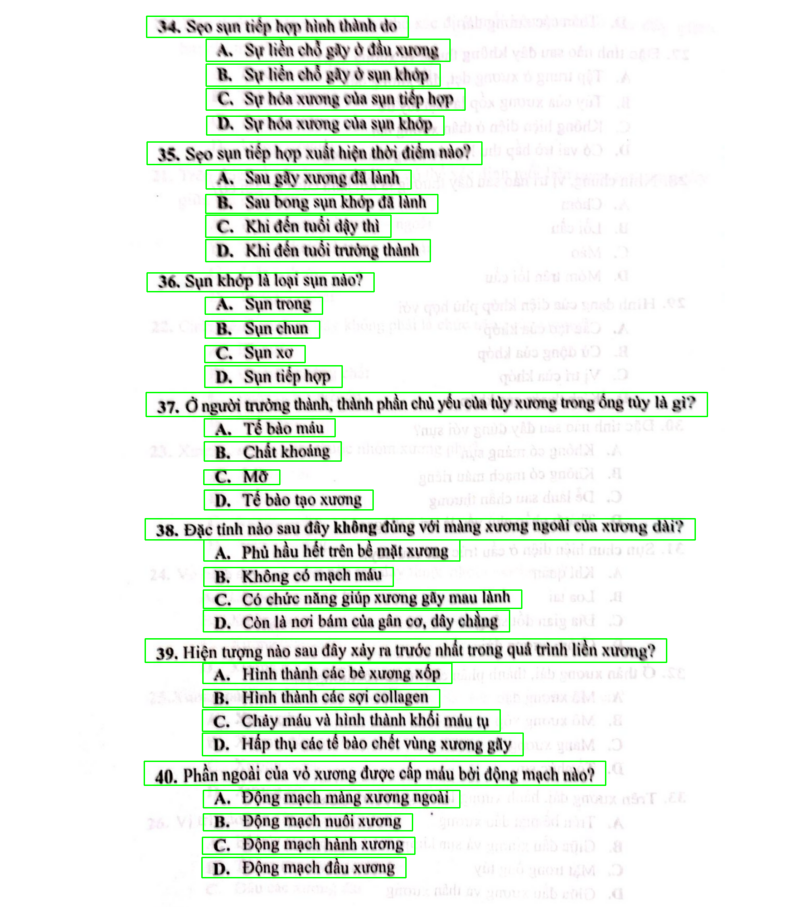

In [66]:
img_bbox = second_page.copy()

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if h > 29 and w > 60:   # lọc noise
      cv2.rectangle(img_bbox, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(10, 12))
plt.imshow(cv2.cvtColor(img_bbox, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()